In [1]:
import PythonicDISORT
from PythonicDISORT.subroutines import _compare
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import pi

Previously saved reference solutions will be loaded if F2PY-wrapped Stamnes' DISORT is unavailable.

In [2]:
disort_is_installed = True
try:
    import disort
except ImportError:
    disort_is_installed = False

# Table of Contents
* [3a and setup](#3a-and-setup)
* [3b](#3b)


# Test Problem 3:  Henyey-Greenstein Scattering

Compare to Table 37 of Van de Hulst, H.C., 1980: *Multiple Light Scattering, Tables, Formulas and Applications*, Volume 2, Academic Press, New York.

# 3a and setup

**PythonicDISORT**

In [3]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1  # One layer of thickness 1 (medium-thick atmosphere)
omega_arr = 1 - 1e-6  # Reduced from 1 (conservative scattering) which is not implemented
NQuad = 16  # 16 streams (8 quadrature nodes for each hemisphere)
Leg_coeffs_all = 0.75 ** np.arange(32)  # Henyey-Greenstein phase function
mu0 = 1  # Cosine of solar zenith angle (directly downwards)
I0 = pi / mu0  # Intensity of direct beam
phi0 = pi  # Azimuthal angle of direct beam

# Optional (used)
f_arr = Leg_coeffs_all[NQuad]  # For delta-M scaling (improves accuracy, especially for fluxes)
NT_cor = True  # Turn on NT corrections (improves accuracy of intensity field; no effect on fluxes)

# Optional (unused)
NLeg = None
NLoops = None
b_pos = 0
b_neg = 0
only_flux = False
BDRF_Fourier_modes = []
s_poly_coeffs = np.array([[]])
use_sparse_NLayers = 13

####################################################################################################

In [4]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=NT_cor
)

**Setup for tests**

In [5]:
# Reorder mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# We may not want to compare intensities around the direct beam
deg_around_beam_to_not_compare = 0
mu_to_compare = (
    np.abs(np.arccos(np.abs(mu_arr_RO)) - np.arccos(mu0)) * 180 / pi
    > deg_around_beam_to_not_compare
)
mu_test_arr_RO = mu_arr_RO[mu_to_compare]

In [6]:
# Number of phi grid points
Nphi = 2
phi_arr = np.random.random(Nphi) * 2 * pi

# tau test points
tau_test_arr = np.array([0, 1])
Ntau = len(tau_test_arr)

**Stamnes' DISORT**

In [7]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: 33]
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [8]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/3a_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [9]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 8.888795020312035e-06
Difference ratio = 3.5931389327204446e-05

Downward (diffuse) fluxes
Difference = 1.0967254665877249e-05
Difference ratio = 1.0000000024806002

Direct (downward) fluxes
Difference = 8.742278012618954e-08
Difference ratio = 3.1740779073332835e-08

Intensities

At tau = 1
Max pointwise difference = 0.0001273089511169001
At tau = 0
Max pointwise difference ratio = 0.00031120558815901975



**Does the test pass?**

In [10]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/3a_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [11]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

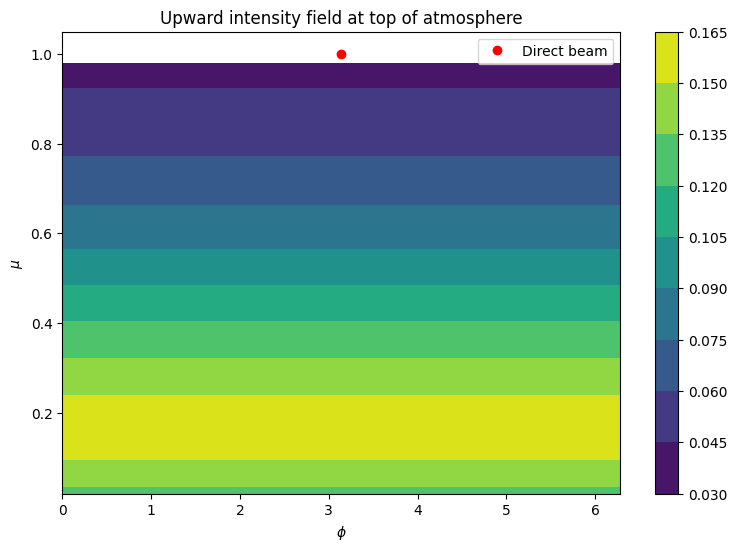

In [12]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

----------

# 3b

**PythonicDISORT**

In [13]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 8
omega_arr = 1 - 1e-6  # Reduced from 1 (conservative scattering) which is not implemented
NQuad = 16
Leg_coeffs_all = 0.75 ** np.arange(32)
mu0 = 1
I0 = pi / mu0
phi0 = pi

# Optional (used)
f_arr = Leg_coeffs_all[NQuad]
NT_cor = True

# Optional (unused)
NLeg=None
NLoops=None
b_pos=0
b_neg=0
only_flux=False
BDRF_Fourier_modes=[]
s_poly_coeffs=np.array([[]])
use_sparse_NLayers=13

####################################################################################################

In [14]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=NT_cor
)

**Stamnes' DISORT**

In [15]:
# tau test points
tau_test_arr = np.array([0, 8])
Ntau = len(tau_test_arr)

In [16]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: 33]
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [17]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/3b_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [18]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 3.8712355521353056e-06
Difference ratio = 1.000000000806446

Downward (diffuse) fluxes
Difference = 6.616944575377204e-06
Difference ratio = 4.270238061761433e-06

Direct (downward) fluxes
Difference = 8.742278012618954e-08
Difference ratio = 2.7827534417466256e-08

Intensities

At tau = 0
Max pointwise difference = 1.6082667769978798e-05
At tau = 8
Max pointwise difference ratio = 8.351734548829836e-05



**Does the test pass?**

In [19]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/3b_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [20]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

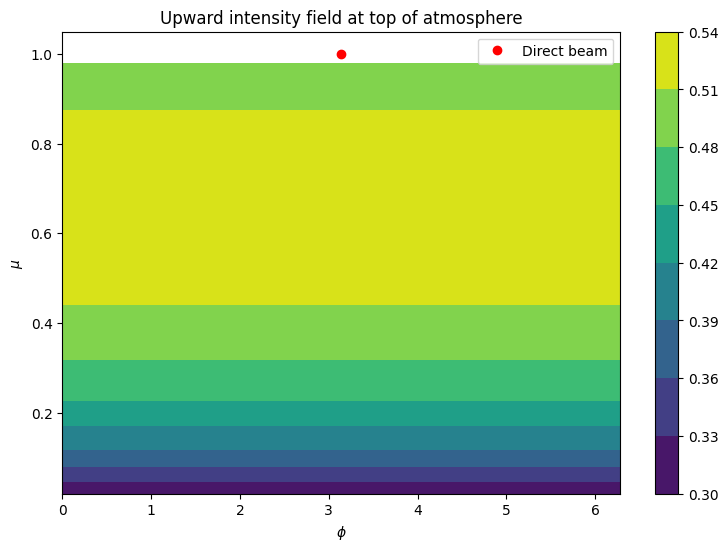

In [21]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

-------